In [190]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import os

from scipy.stats import chi2_contingency, f_oneway
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from Utils.Feature_Eng import cramers_v

pd.set_option('display.max_columns', None)

In [191]:
df = pd.read_csv("../Data/cleaned_df.csv", index_col=0)

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


In [192]:
df['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [193]:
# Perishable Items and Non-Perishable Items

# perishable_items = ['Fruits and Vegetables', 'Dairy', 'Meat', 'Breads', 'Breakfast', 'Seafood']
# non_perishable_items = ['Snack Foods', 'Household', 'Frozen Foods', 'Canned', 'Baking Goods', 'Health and Hygiene', 'Soft Drinks', 'Hard Drinks']
# unknown = ['Others', 'Starchy Foods']

# item_type = []

# for item in df['Item_Type']:
#     if item in perishable_items:
#         item_type.append('Perishable')
#     elif item in non_perishable_items:
#         item_type.append('Non-Perishable')
#     else:
#         item_type.append('Unknown')

# df['Item_Type_Encoded'] = item_type

In [194]:
# FD (Food), DR (Drink), NC (Non-Consumable) Item_Identifier categories

df['Item_Categories'] = df['Item_Identifier'].replace({'^FD[A-Z][0-9]{2}':'Food', '^DR[A-Z]*[0-9]*':'Drink', '^NC[A-Z]*[0-9]*':'Non-Consumable'}, regex=True)

In [195]:
item_grouped = df.groupby(['Item_Type', 'Item_Categories']).size().unstack(fill_value=0)

item_grouped

Item_Categories,Drink,Food,Non-Consumable
Item_Type,,,
Baking Goods,0,648,0
Breads,0,251,0
Breakfast,0,110,0
Canned,0,649,0
Dairy,140,542,0
Frozen Foods,0,856,0
Fruits and Vegetables,0,1232,0
Hard Drinks,214,0,0
Health and Hygiene,0,0,520


In [196]:
item_grouped_crosstab = pd.crosstab(df['Item_Type'], df['Item_Categories'])
item_grouped_crosstab

Item_Categories,Drink,Food,Non-Consumable
Item_Type,,,
Baking Goods,0,648,0
Breads,0,251,0
Breakfast,0,110,0
Canned,0,649,0
Dairy,140,542,0
Frozen Foods,0,856,0
Fruits and Vegetables,0,1232,0
Hard Drinks,214,0,0
Health and Hygiene,0,0,520


In [197]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable


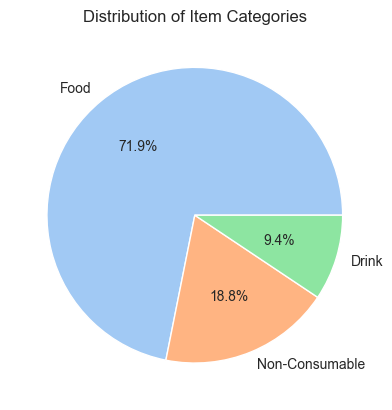

In [198]:
# Distribution of Item Categories

plt.pie(df['Item_Categories'].value_counts(), 
        labels=df['Item_Categories'].value_counts().index, 
        autopct='%.1f%%',
        colors=sns.color_palette('pastel'))

plt.title('Distribution of Item Categories')
plt.show()

In [199]:
# Outlet_Age

df['Outlet_Age'] = 2014-df['Outlet_Establishment_Year']

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27


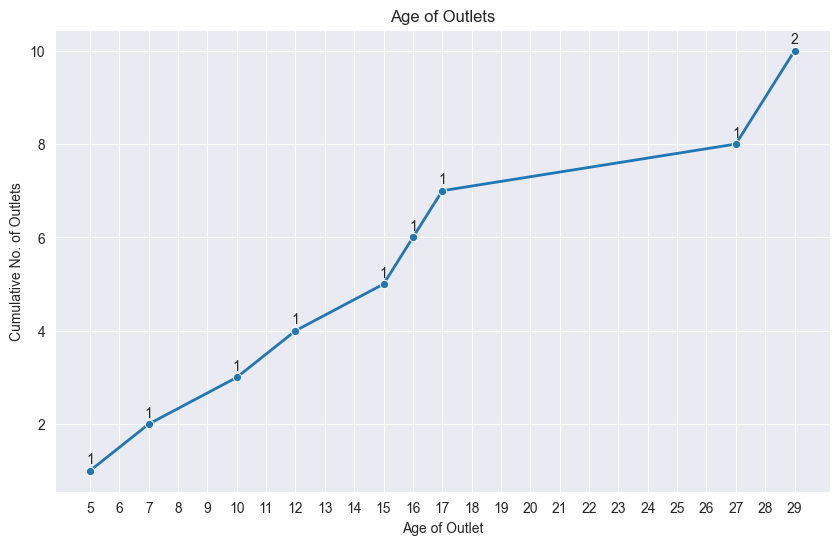

In [200]:
# Outlet_Age

# Step 1: Sort the data by establishment year and outlet identifier to ensure correct order
df_sorted = df.sort_values(by=['Outlet_Age', 'Outlet_Identifier'])

# Step 2: Create a new DataFrame for counting unique outlets
outlet_counts = df_sorted.groupby('Outlet_Age')['Outlet_Identifier'].nunique().reset_index()
outlet_counts.columns = ['Outlet_Age', 'Unique_Outlets']

# Step 3: Calculate the cumulative count of unique outlets established over the years
outlet_counts['Cumulative_Outlets'] = outlet_counts['Unique_Outlets'].cumsum()

# Step 4: Plot the timeline graph using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Outlet_Age', y='Cumulative_Outlets', data=outlet_counts, marker='o', linewidth=2)

# Step 5: Customize the graph
plt.title('Age of Outlets')
plt.xlabel('Age of Outlet')
plt.ylabel('Cumulative No. of Outlets')

# Step 6: Customize x-axis ticks to show more years
plt.xticks(ticks=range(outlet_counts['Outlet_Age'].min(), outlet_counts['Outlet_Age'].max() + 1, 1))

# Step 7: Annotate the cumulative outlets established each year
for index, row in outlet_counts.iterrows():
    # Use the cumulative total for annotation
    plt.annotate(f'{row["Unique_Outlets"]}', 
                 xy=(row['Outlet_Age'], row['Cumulative_Outlets']), 
                 xytext=(0, 5),  # Offset the annotation vertically
                 textcoords='offset points', 
                 ha='center', 
                 fontsize=10)

plt.grid(True)
# Display the plot
plt.show()

In [201]:
# Item_Unit_Price

df['Item_Unit_Price'] = df['Item_MRP']/df['Item_Weight']

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_Unit_Price
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,26.861204
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,8.153581
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,8.092457
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16,9.484115
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,6.031512


In [202]:
sns.set_style('darkgrid')
fig = px.histogram(df, x='Item_Unit_Price', nbins=500)

fig.update_xaxes(showgrid=True, dtick=10)

fig.update_layout(
    title={
        'text': 'Distribution of Item Unit Price',
        'x': 0.5,  # Center the title
    },
    xaxis_title='Item Unit Price (USD)',
    yaxis_title='Frequency'
)

fig.show()

# Very few values have higher price and higher weight

In [203]:
# Item_MRP Categories 0-69, 70-135, 136-202, 203-270

mrp_list = []

for item_price in df['Item_MRP'].astype('int'):
    if item_price < 70:
        mrp_list.append('First Category')
    elif item_price in range(70, 136):
        mrp_list.append('Second Category')
    elif item_price in range(136, 203):
        mrp_list.append('Third Category')
    else:
        mrp_list.append('Fourth Category')

df['Item_MRP_Categories'] = mrp_list

df[['Item_MRP', 'Item_MRP_Categories']].head(10)


,Item_MRP,Item_MRP_Categories
0,249.8092,Fourth Category
1,48.2692,First Category
2,141.6180,Third Category
3,182.0950,Third Category
4,53.8614,First Category
5,51.4008,First Category
6,57.6588,First Category
7,107.7622,Second Category
8,96.9726,Second Category
9,187.8214,Third Category


In [204]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_Unit_Price,Item_MRP_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,26.861204,Fourth Category
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,8.153581,First Category
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,8.092457,Third Category
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16,9.484115,Third Category
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,6.031512,First Category


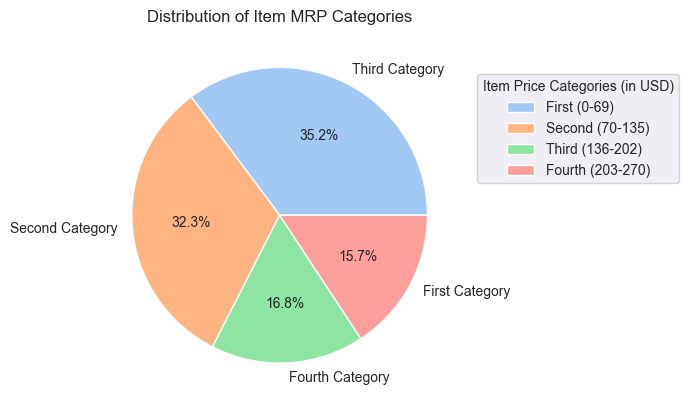

In [205]:
# Distribution of Item MRP Categories 0-69, 70-135, 136-202, 203-270

plt.pie(df['Item_MRP_Categories'].value_counts(), 
        labels=df['Item_MRP_Categories'].value_counts().index, 
        autopct='%.1f%%',
        colors=sns.color_palette('pastel'))

plt.title('Distribution of Item MRP Categories')
labels = ['First (0-69)', 'Second (70-135)', 
          'Third (136-202)', 'Fourth (203-270)']
plt.legend(labels, title='Item Price Categories (in USD)', loc='upper right', bbox_to_anchor=(1.6, 0.9))

plt.show()

## Statistical Testing

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, 0 to 8522
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Item_Categories            8523 non-null   object 
 13  Outlet_Age                 8523 non-null   int64  
 1

In [207]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_Unit_Price,Item_MRP_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,26.861204,Fourth Category
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,8.153581,First Category
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,8.092457,Third Category
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16,9.484115,Third Category
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,6.031512,First Category


In [208]:
# Chi-Square Test Outlet_Size & Outlet_Location_Type

outlet_size_by_type = pd.crosstab(df['Outlet_Size'], df['Outlet_Location_Type'])
outlet_size_by_type


Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
Large,0,0,932
Medium,930,0,1863
Small,1458,2785,555


In [209]:
# H0: Two variables are independent of each other
# H1: Two variables are associated/dependent with each other
# P-Value <= 0.05, Reject Null Hypothesis
# P-Value > 0.05, Fail to Reject Null Hypothesis.
result = chi2_contingency(outlet_size_by_type)
print('P-Value:', result[1])
print(result)

# Outlet_Location_Type and Outlet_Size are likely associated with each other.

P-Value: 0.0
Chi2ContingencyResult(statistic=4806.778592709207, pvalue=0.0, dof=4, expected_freq=array([[ 261.13058782,  304.54300129,  366.32641089],
       [ 782.55121436,  912.64871524, 1097.8000704 ],
       [1344.31819782, 1567.80828347, 1885.87351871]]))


In [210]:
df_encoded_outlet = pd.DataFrame()
label_encoder = preprocessing.LabelEncoder()

for i in df[['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']].columns:
    df_encoded_outlet[i] = label_encoder.fit_transform(df[i])

df_encoded_outlet.value_counts()

Outlet_Size  Outlet_Location_Type  Outlet_Type
2            1                     1              2785
1            2                     3               935
0            2                     1               932
1            0                     1               930
2            0                     1               930
1            2                     2               928
2            2                     0               555
             0                     0               528
Name: count, dtype: int64

In [211]:
nested_list = []

for var1 in df_encoded_outlet:
    arr = []
    for var2 in df_encoded_outlet:
        cramers = cramers_v(df_encoded_outlet[var1], df_encoded_outlet[var2])
        arr.append(round(cramers, 2)) 
    
    nested_list.append(arr)

cramers_result = np.array(nested_list)
df_cramers_outlet = pd.DataFrame(cramers_result, columns=df_encoded_outlet.columns, index=df_encoded_outlet.columns)

df_cramers_outlet

# Outlet_Size & Outlet_Type : 1.26
# Outlet_Location_Type & Outlet_Size : 1.13
# Outlet_Type & Outlet_Location_Type : 1.11

,Outlet_Size,Outlet_Location_Type,Outlet_Type
Outlet_Size,4.00,1.13,1.26
Outlet_Location_Type,1.13,4.00,1.11
Outlet_Type,1.26,1.11,9.00


In [212]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_Unit_Price,Item_MRP_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,26.861204,Fourth Category
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,8.153581,First Category
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,8.092457,Third Category
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16,9.484115,Third Category
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,6.031512,First Category


In [213]:
# Item_Fat_Content Item_Type Item_Categories Item_MRP_Categories

# Chi-Square Test Item_Fat_Content & Item_Type
item_fatcontent_by_type = pd.crosstab(df['Item_Fat_Content'], df['Item_Type'])
item_fatcontent_by_type

# H0: Two variables are independent of each other
# H1: Two variables are associated/dependent with each other
# P-Value <= 0.05, Reject Null Hypothesis
# P-Value > 0.05, Fail to Reject Null Hypothesis.
result = chi2_contingency(item_fatcontent_by_type)
print('P-Value for Item_Fat_Content & Item_Type:', result[1])

# Chi-Square Test Item_Fat_Content & Item_MRP_Categories
item_fatcontent_by_mrp = pd.crosstab(df['Item_Fat_Content'], df['Item_MRP_Categories'])
item_fatcontent_by_mrp

result = chi2_contingency(item_fatcontent_by_mrp)
print('P-Value for Item_Fat_Content & Item_MRP_Categories:', result[1])

# Chi-Square Test Item_Type & Item_MRP_Categories
item_type_by_mrp = pd.crosstab(df['Item_Type'], df['Item_MRP_Categories'])
item_type_by_mrp

result = chi2_contingency(item_type_by_mrp)
print('P-Value for Item_Type & Item_MRP_Categories:', result[1])

# Chi-Square Test Item_Fat_Content & Item_Categories
item_fatcontent_by_categories = pd.crosstab(df['Item_Fat_Content'], df['Item_Categories'])
item_fatcontent_by_categories

result = chi2_contingency(item_fatcontent_by_categories)
print('P-Value for Item_Fat_Content & Item_Categories:', result[1])

# Chi-Square Test Item_Categories & Item_MRP_Categories
item_categories_by_mrp = pd.crosstab(df['Item_Categories'], df['Item_MRP_Categories'])
item_categories_by_mrp

result = chi2_contingency(item_categories_by_mrp)
print('P-Value for Item_Categories & Item_MRP_Categories:', result[1])

# Chi-Square Test Item_Type & Item_Categories
item_type_by_categories = pd.crosstab(df['Item_Type'], df['Item_Categories'])
item_type_by_categories

result = chi2_contingency(item_type_by_categories)
print('P-Value for Item_Type & Item_Categories:', result[1])

P-Value for Item_Fat_Content & Item_Type: 0.0
P-Value for Item_Fat_Content & Item_MRP_Categories: 0.799347088761953
P-Value for Item_Type & Item_MRP_Categories: 1.4594550193197222e-38
P-Value for Item_Fat_Content & Item_Categories: 0.0
P-Value for Item_Categories & Item_MRP_Categories: 8.407436301255446e-16
P-Value for Item_Type & Item_Categories: 0.0


In [214]:
df_encoded_item = pd.DataFrame()
label_encoder = preprocessing.LabelEncoder()

for i in df[['Item_Fat_Content', 'Item_Type', 'Item_Categories', 'Item_MRP_Categories']].columns:
    df_encoded_item[i] = label_encoder.fit_transform(df[i])

df_encoded_item.value_counts()

Item_Fat_Content  Item_Type  Item_Categories  Item_MRP_Categories
0                 9          2                3                      345
                  13         1                3                      288
                  9          2                2                      264
1                 6          1                3                      236
0                 6          1                2                      219
                                                                    ... 
1                 14         0                2                       10
0                 2          1                1                        8
1                 2          1                1                        7
                  14         0                1                        7
                  12         1                1                        4
Name: count, Length: 112, dtype: int64

In [215]:
nested_list = []

for var1 in df_encoded_item:
    arr = []
    for var2 in df_encoded_item:
        cramers = cramers_v(df_encoded_item[var1], df_encoded_item[var2])
        arr.append(round(cramers, 2)) 
    
    nested_list.append(arr)

cramers_result = np.array(nested_list)
df_cramers_item = pd.DataFrame(cramers_result, columns=df_encoded_item.columns, index=df_encoded_item.columns)

df_cramers_item

# Item_Fat_Content & Item_Type : 0.18
# Item_Fat_Content & Item_Categories : 0.18
# Item_Fat_Content & Item_MRP_Categories : 0.00
# Item_Type & Item_Categories : 3.69
# Item_Type & Item_MRP_Categories : 0.10
# Item_Categories & Item_MRP_Categories : 0.02

,Item_Fat_Content,Item_Type,Item_Categories,Item_MRP_Categories
Item_Fat_Content,1.00,0.18,0.18,0.00
Item_Type,0.18,225.00,3.69,0.10
Item_Categories,0.18,3.69,4.00,0.02
Item_MRP_Categories,0.00,0.10,0.02,9.00


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, 0 to 8522
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Item_Categories            8523 non-null   object 
 13  Outlet_Age                 8523 non-null   int64  
 1

In [217]:
# H0: Two variables are not correlated with each other
# H1: Two variables are correlated with each other
# P-Value <= 0.05, Reject Null Hypothesis
# P-Value > 0.05, Fail to Reject Null Hypothesis.

# One way ANOVA Outlet_Type & Item_Outlet_Sales
outlet_type_by_item_sales = df.groupby('Outlet_Type')['Item_Outlet_Sales'].apply(list)
outlet_type_by_item_sales

Outlet_Type
Grocery Store        [732.38, 214.3876, 178.4344, 125.8362, 163.786...
Supermarket Type1    [3735.138, 2097.27, 994.7052, 343.5528, 1076.5...
Supermarket Type2    [443.4228, 556.6088, 1621.8888, 2741.7644, 306...
Supermarket Type3    [4022.7636, 2303.668, 4064.0432, 2797.6916, 38...
Name: Item_Outlet_Sales, dtype: object

In [218]:
anova_result = f_oneway(*outlet_type_by_item_sales)
anova_result

# Outlet_Type & Item_Outlet_Sales are correlated to each other.

F_onewayResult(statistic=894.6500119018012, pvalue=0.0)

In [219]:
# Item_Visibility Item_Categories Item_Outlet_Sales Item_MRP

# anova_item_group = df.groupby('Item_Categories')[['Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']].apply(list)

group_col = 'Item_Categories'
num_col = ['Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
anova_results = {}

for ncol in num_col:
    anova_item_group = [group[ncol].values for name, group in df.groupby(group_col)]
    anova_item_result = f_oneway(*anova_item_group)
    anova_results[ncol] = {'F-Statistic':anova_item_result.statistic,
                               'P-Value':anova_item_result.pvalue}
    
for ncol, results in anova_results.items():
    print(f'Anova Results for {ncol}:')
    print(f"F-Statistic: {results['F-Statistic']}")
    print(f"P-Value: {results['P-Value']}")
    print('-'*40)

# Item_Visibility, Item_Outlet_Sales & Item_MRP are correlated with Item_Categories.

Anova Results for Item_Visibility:
F-Statistic: 21.38547455678741
P-Value: 5.44052537043732e-10
----------------------------------------
Anova Results for Item_MRP:
F-Statistic: 11.474950241548537
P-Value: 1.0548539040517414e-05
----------------------------------------
Anova Results for Item_Outlet_Sales:
F-Statistic: 6.278765679145161
P-Value: 0.0018844050713309338
----------------------------------------


In [220]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_Unit_Price,Item_MRP_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,26.861204,Fourth Category
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,8.153581,First Category
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,8.092457,Third Category
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,16,9.484115,Third Category
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,6.031512,First Category


In [221]:
# 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age'
# Drop: 'Item_Identifier', 'Item_Type', 'Item_Unit_Price', 'Outlet_Establishment_Year'

df.drop(columns=['Item_Identifier', 'Item_Type', 'Item_Unit_Price', 'Outlet_Establishment_Year'], inplace=True)

## Encoding

In [222]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_MRP_Categories
0,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,Food,15,Fourth Category
1,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drink,5,First Category
2,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,Food,15,Third Category
3,19.20,Regular,0.000000,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,Food,16,Third Category
4,8.93,Low Fat,0.000000,53.8614,OUT013,Large,Tier 3,Supermarket Type1,994.7052,Non-Consumable,27,First Category


In [223]:
df_category_list = ['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 
    'Outlet_Type', 'Item_Categories', 'Item_MRP_Categories']

for col in df_category_list:
    print(df[col].value_counts())
    print('------------------------')


Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64
------------------------
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64
------------------------
Outlet_Size
Small     4798
Medium    2793
Large      932
Name: count, dtype: int64
------------------------
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64
------------------------
Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64
------------------------
Item_Categories
Food              6125
Non-Consumable    1599
Drink              799
Name: count, dtype: int64
------------------------
Item_MRP_Categories
Third Category     3002
Second Category    2751
Fourth Category    1429
First Category     1341
Name: count, dtype: int64
---------------------

In [224]:
# 'Item_Fat_Content': Low Fat, Regular
# 'Outlet_Identifier': 10 unique values starting ewith 'OUT'
# 'Outlet_Size': Small, Medium, Large
# 'Outlet_Location_Type': Tier1, Tier2, Tier3
# 'Outlet_Type': SupermarketType[1-3], Grocery Store
# 'Item_Categories': Food, Drink, Non-Consumable
# 'Item_MRP_Categories': First, Second, Third and Fourth Category

label_encoding = preprocessing.LabelEncoder()

col_to_encode = ['Item_Fat_Content', 'Item_Categories', 'Item_MRP_Categories', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

df_le = df.copy()
for i in col_to_encode:
    df_le[i] = label_encoding.fit_transform(df[i])

df_le.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Categories,Outlet_Age,Item_MRP_Categories
0,9.30,0,0.016047,249.8092,9,1,0,1,3735.1380,1,15,1
1,5.92,1,0.019278,48.2692,3,1,2,2,443.4228,0,5,0
2,17.50,0,0.016760,141.6180,9,1,0,1,2097.2700,1,15,3
3,19.20,1,0.000000,182.0950,0,2,2,0,732.3800,1,16,3
4,8.93,0,0.000000,53.8614,1,0,2,1,994.7052,2,27,0


In [225]:
for col in df_category_list:
    print(df_le[col].value_counts())
    print('------------------------')

Item_Fat_Content
0    5517
1    3006
Name: count, dtype: int64
------------------------
Outlet_Identifier
5    935
1    932
9    930
8    930
6    930
7    929
3    928
2    926
0    555
4    528
Name: count, dtype: int64
------------------------
Outlet_Size
2    4798
1    2793
0     932
Name: count, dtype: int64
------------------------
Outlet_Location_Type
2    3350
1    2785
0    2388
Name: count, dtype: int64
------------------------
Outlet_Type
1    5577
0    1083
3     935
2     928
Name: count, dtype: int64
------------------------
Item_Categories
1    6125
2    1599
0     799
Name: count, dtype: int64
------------------------
Item_MRP_Categories
3    3002
2    2751
1    1429
0    1341
Name: count, dtype: int64
------------------------


In [226]:
df_le.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857890,4.232804,4.555,9.310000,12.867061,16.000000,21.350000
Item_Fat_Content,8523.0,0.352693,0.477836,0.000,0.000000,0.000000,1.000000,1.000000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Identifier,8523.0,4.722281,2.837201,0.000,2.000000,5.000000,7.000000,9.000000
Outlet_Size,8523.0,1.453596,0.683084,0.000,1.000000,2.000000,2.000000,2.000000
Outlet_Location_Type,8523.0,1.112871,0.812757,0.000,0.000000,1.000000,2.000000,2.000000
Outlet_Type,8523.0,1.201220,0.796459,0.000,1.000000,1.000000,1.000000,3.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800
Item_Categories,8523.0,1.093864,0.522090,0.000,1.000000,1.000000,1.000000,2.000000


In [227]:
df_le.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           8523 non-null   float64
 1   Item_Fat_Content      8523 non-null   int64  
 2   Item_Visibility       8523 non-null   float64
 3   Item_MRP              8523 non-null   float64
 4   Outlet_Identifier     8523 non-null   int64  
 5   Outlet_Size           8523 non-null   int64  
 6   Outlet_Location_Type  8523 non-null   int64  
 7   Outlet_Type           8523 non-null   int64  
 8   Item_Outlet_Sales     8523 non-null   float64
 9   Item_Categories       8523 non-null   int64  
 10  Outlet_Age            8523 non-null   int64  
 11  Item_MRP_Categories   8523 non-null   int64  
dtypes: float64(4), int64(8)
memory usage: 865.6 KB


In [228]:
df_le.to_csv("../Data/df_le.csv")

In [229]:
df_oh = df.copy()

df_oh = pd.get_dummies(df, columns=col_to_encode, dtype=int)

df_oh.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Categories_Drink,Item_Categories_Food,Item_Categories_Non-Consumable,Item_MRP_Categories_First Category,Item_MRP_Categories_Fourth Category,Item_MRP_Categories_Second Category,Item_MRP_Categories_Third Category,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Large,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,3735.1380,15,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,443.4228,5,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,2097.2700,15,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,732.3800,16,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,994.7052,27,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [230]:
df_oh.to_csv("../Data/df_oh.csv")